**Importing the Dependencies**

In [2]:
import sys
!{sys.executable} -m pip install hyperopt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

**Load the dataset**

In [4]:
data = pd.read_csv('train.csv')
actual_data = pd.read_csv('train.csv')

In [5]:
data.shape

(20800, 5)

In [6]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \r\nAn Iranian woman has been sentenced ...,1


# Preprocessing

**Remove NULL values**

In [7]:
data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

**Remove unwanted columns**

In [10]:
data.drop(columns=['id'], inplace=True)

# Exploratory Data Analysis

In [11]:
from tabulate import tabulate

alldata = ['All', data['title'].apply(len).mean(), data['title'].apply(len).min(), data['title'].apply(len).max()]
realdata = ['Real', data['title'][data['label'] == 0].apply(len).mean(), data['title'][data['label'] == 0].apply(len).min(), data['title'][data['label'] == 0].apply(len).max()]
fakedata = ['Fake', data['title'][data['label'] == 1].apply(len).mean(), data['title'][data['label'] == 1].apply(len).min(), data['title'][data['label'] == 1].apply(len).max()]

table = [['Label', 'Mean Length', 'Min Length', 'Max Length'], alldata, realdata, fakedata]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤═══════════════╤══════════════╤══════════════╕
│ Label   │   Mean Length │   Min Length │   Max Length │
╞═════════╪═══════════════╪══════════════╪══════════════╡
│ All     │       74.7023 │            3 │          456 │
├─────────┼───────────────┼──────────────┼──────────────┤
│ Real    │       79.6142 │           22 │          175 │
├─────────┼───────────────┼──────────────┼──────────────┤
│ Fake    │       68.2798 │            3 │          456 │
╘═════════╧═══════════════╧══════════════╧══════════════╛


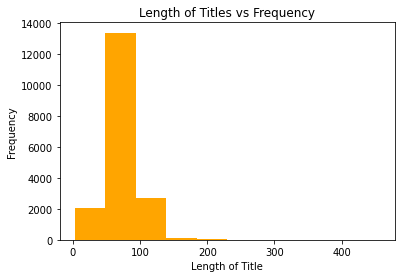

In [12]:
plt.title('Length of Titles vs Frequency')
plt.xlabel('Length of Title')
plt.ylabel('Frequency')
plt.hist(data['title'].apply(len), color='orange')
plt.show()

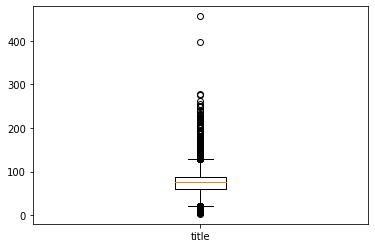

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(['title'])
plt.boxplot(data['title'].apply(len))
plt.show()

[('admin', 193), ('Pakalert', 86), ('Eddy Lavine', 85), ('Starkman', 84), ('Alex Ansary', 82), ('Gillian', 82), ('Editor', 81), ('noreply@blogger.com (Alexander Light)', 80)]


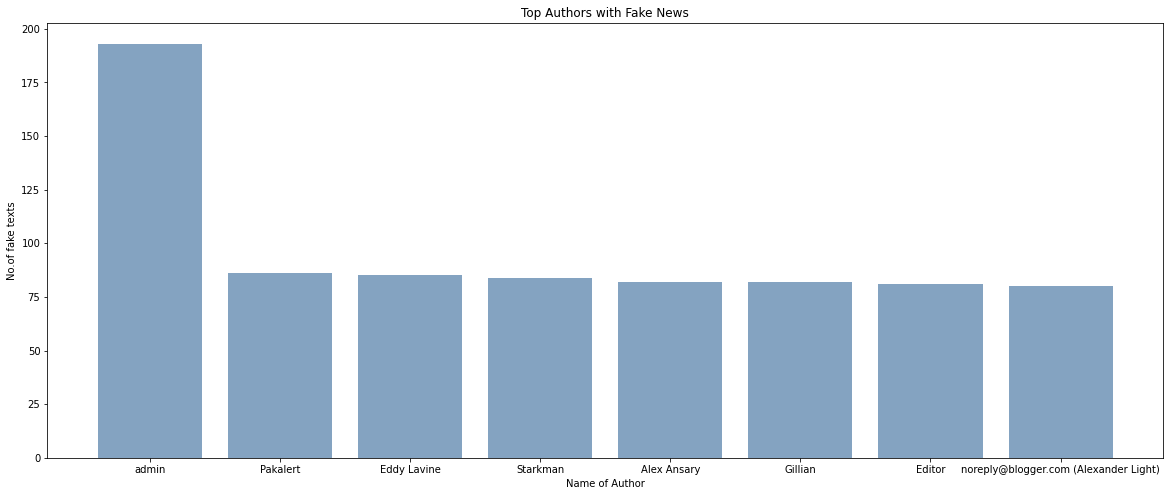

In [14]:
from collections import Counter

c = Counter(data['author'][data['label'] == 1]).most_common(8)
print(c)

x, y = zip(*c)

plt.figure(figsize=(20, 8))
plt.title('Top Authors with Fake News')
plt.xlabel('Name of Author')
plt.ylabel('No.of fake texts')
plt.bar(x, y, color=(0.2, 0.4, 0.6, 0.6))
plt.show()

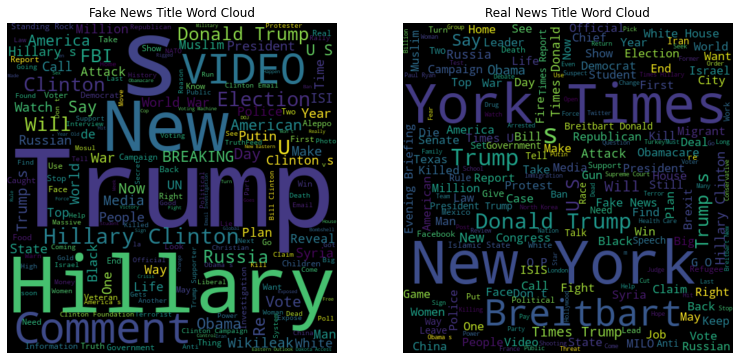

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


plt.figure(figsize=(13, 7))


# Fake News Word Cloud

text=(' '.join(data['title'][data['label'] == 1]))
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.subplot(1, 2, 1)
plt.title('Fake News Title Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


# Real News Word Cloud

text=(' '.join(data['title'][data['label'] == 0]))
wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.subplot(1, 2, 2)
plt.title('Real News Title Word Cloud')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

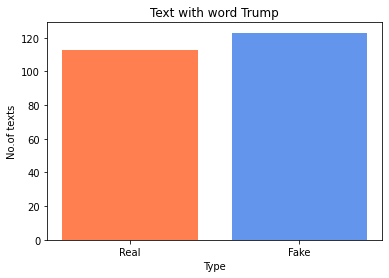

In [16]:
fake_trump_len = len(data[data['text'].str.contains('trump')][data['label'] == 1])
real_trump_len = len(data[data['text'].str.contains('trump')][data['label'] == 0])

plt.title('Text with word Trump')
plt.xlabel('Type')
plt.ylabel('No.of texts')
plt.bar(['Real', 'Fake'], [real_trump_len, fake_trump_len], color=['coral', 'cornflowerblue'])
plt.show()

**Combine necessary columns**

In [17]:
data['content'] = data['author'] + '\n' + data['title'] + '\n' + data['text']
data.drop(columns = ['title', 'author', 'text'], inplace=True)

# Tokenization
It is the process of dividing a text into smaller units (each word will be an index in an array)

In [18]:
data['content'] = data.apply(lambda row: word_tokenize(row['content']), axis=1)
# data.iloc[0]['content']

# Lemmatization
It removes the endings of the word to the root word. It reduces the word children to a child.

In [ ]:
lemmatizer = WordNetLemmatizer()

def pos_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_tokens(tokens):
    nltk_tagged = pos_tag(tokens)  
    wordnet_tagged = map(lambda x: (x[0], pos_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tokens = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_tokens.append(word)
        else:        
            lemmatized_tokens.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_tokens


data['content'] = data['content'].apply(lemmatize_tokens)
# data.iloc[0]['content']

# Stop words Removal
Words like the and for will be eliminated from our dataset because they take too much room.

In [ ]:
stops = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: [i for i in x if i not in stops and len(i) > 1])
data.iloc[0]['content']

In [ ]:
data['content'] = data['content'].apply(lambda x: ' '.join(x))

actual = actual_data.iloc[1]['text'][:535]
processed = data.iloc[1]['content'][65:464]

def print_side_by_side(a, b, size=50, space=4):
    print("Raw Text".ljust(size) + " " * (space // 2) + '|' + " " * (space // 2) + "Processed Text")
    print("="*(2 * size + space))
    while a or b:
        print(a[:size].ljust(size) + " " * (space // 2) + '|' + " " * (space // 2) + b[:size])
        a = a[size:]
        b = b[size:]

print_side_by_side(actual,processed)

# Train Test Split

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(data['content'], data['label'], test_size=0.3)

# Word Vectorization: TFIDF

- **Term Frequency:** This summarizes how often a given word appears within a document. <br/>
    TF = (#occurences of the word) / (#words in the doc)
- **Inverse Document Frequency:** This down scales words that appear a lot across documents. <br/>
    IDF = log((#documents) / (#documents containing the given word))
    
    TFIDF = TF * IDF

Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

In [ ]:
 = TfidfVectorizer(max_features=5000)

tfidf_vect.fit(data['content'])

train_X_Tfidf = tfidf_vect.transform(train_X)
test_X_Tfidf = tfidf_vect.transform(test_X)


print(tfidf_vect.vocabulary_)

# Naive Bayes

In [ ]:
Naive = MultinomialNB()

In [ ]:
print("Cross Validation Score -> ", cross_val_score(Naive, train_X_Tfidf, train_Y).mean())

from hyperopt import hp, tpe, fmin,STATUS_OK,Trials

def accuracy_model(params):
    clf = MultinomialNB(**params)
    return (cross_val_score(clf, train_X_Tfidf, train_Y).mean(), clf)

param_space = {
    'alpha': hp.choice('alpha', np.linspace(0.5, 1.5, 6)),
    'fit_prior': hp.choice('fit_prior', [True, False])
}

best = 0
best_clf = MultinomialNB()
best_params = []
def f(params):
    global best, best_clf, best_params
    acc, clf = accuracy_model(params)
    if acc > best:
        best = acc
        best_clf = clf
        best_params = params
    return {'loss': -acc, 'status': STATUS_OK}

fmin(f, param_space , algo=tpe.suggest, max_evals=500)

Naive = best_clf
print('New best:', best, best_params)

In [ ]:
Naive.fit(train_X_Tfidf, train_Y)

In [ ]:
# predict the labels on validation dataset
predictions_NB_test = Naive.predict(test_X_Tfidf)
predictions_NB_train = Naive.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_NB_test = accuracy_score(predictions_NB_test, test_Y) * 100
accuracy_NB_train = accuracy_score(predictions_NB_train, train_Y) * 100

print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB_test, test_Y)*100)

# SVM

In [27]:
SVM = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

# fit the training dataset on the classifier
SVM.fit(train_X_Tfidf, train_Y)

# predict the labels on validation dataset
predictions_SVM_test = SVM.predict(test_X_Tfidf)
predictions_SVM_train = SVM.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_SVM_test = accuracy_score(predictions_SVM_test, test_Y) * 100
accuracy_SVM_train = accuracy_score(predictions_SVM_train, train_Y) * 100

print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM_test, test_Y)*100)

SVM Accuracy Score ->  57.03609187021509


# Decision Tree


In [29]:
Decision_tree = DecisionTreeClassifier()

# fit the training dataset on the classifier
Decision_tree.fit(train_X_Tfidf, train_Y)

# predict the labels on validation dataset
predictions_DT_test = Decision_tree.predict(test_X_Tfidf)
predictions_DT_train = Decision_tree.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_DT_test = accuracy_score(predictions_DT_test, test_Y) * 100
accuracy_DT_train = accuracy_score(predictions_DT_train, train_Y) * 100

print("Decision Tree Accuracy Score -> ",accuracy_score(predictions_DT_test, test_Y)*100)

Decision Tree Accuracy Score ->  94.49507838133431


# Stacking Model

- Base Models are Naive Bayes, SVM and Decision Tree
- Meta Model is Logistic Regression
- Meta Model uses the outputs from the different classifiers to predict the given row's label for its training

In [30]:
estimator_list = [
    ('nb', Naive),
    ('svc', SVM),
    ('dt', Decision_tree)]

# Build stack model
stack_model = StackingClassifier(
    estimators=estimator_list, final_estimator=LogisticRegression()
)

# fit the training dataset on the classifier
stack_model.fit(train_X_Tfidf, train_Y)

# predict the labels on validation dataset
predictions_stack_test = stack_model.predict(test_X_Tfidf)
predictions_stack_train = stack_model.predict(train_X_Tfidf)

# Use accuracy_score function to get the accuracy
accuracy_stack_test = accuracy_score(predictions_stack_test, test_Y) * 100
accuracy_stack_train = accuracy_score(predictions_stack_train, train_Y) * 100

print("Stacked Model Accuracy Score -> ",accuracy_score(predictions_stack_test, test_Y)*100)

Stacked Model Accuracy Score ->  95.8804228946409


In [31]:
train_accuracies = ['Train', accuracy_NB_train, accuracy_SVM_train, accuracy_DT_train, accuracy_stack_train]
test_accuracies = ['Test', accuracy_NB_test, accuracy_SVM_test, accuracy_DT_test, accuracy_stack_test]
table = [['Data Type', 'Naive Bayes', 'SVM', 'Decision Tree', 'Stacked Model'], train_accuracies, test_accuracies]
print('Model Accuracy Scores')
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Model Accuracy Scores
╒═════════════╤═══════════════╤═════════╤═════════════════╤═════════════════╕
│ Data Type   │   Naive Bayes │     SVM │   Decision Tree │   Stacked Model │
╞═════════════╪═══════════════╪═════════╪═════════════════╪═════════════════╡
│ Train       │       92.9291 │ 56.5044 │        100      │         98.9452 │
├─────────────┼───────────────┼─────────┼─────────────────┼─────────────────┤
│ Test        │       91.6697 │ 57.0361 │         94.4951 │         95.8804 │
╘═════════════╧═══════════════╧═════════╧═════════════════╧═════════════════╛


# Making Predictive System

In [ ]:
print("Enter a news data set number to check if the news is real or fake: ")

i = int(input())

predicted = test_X_Tfidf[i]
temp = list(test_Y)
final = temp[i]

prediction = stack_model.predict(predicted)

if (prediction[0] == 0):
  print('Prediction for news -',i,': The news is Real')
else:
  print('Prediction for news -',i,': The news is Fake')

if (final == 0):
  print('Original news -',i,': The news is Real')
else:
  print('Original news -',i,': The news is Fake')

In [ ]:
import copy
temp = copy.deepcopy(test_X)

In [ ]:
s = input()
s = word_tokenize(s)
print(s)
s = lemmatize_tokens(s)
print(s)
s = [i for i in s if i not in stops and len(i) > 1]
print(s)
s = ' '.join(s)

temp[0] = s 

tf = tfidf_vect.fit_transform(temp)
print(tf[0])
a = stack_model.predict(tf[0])

if a[0] == 1:
    print('Fake')
else:
    print('Real')

In [ ]:
s = input()
s = word_tokenize(s)
s = lemmatize_tokens(s)
s = [i for i in s if i not in stops and len(i) > 1]
s = ' '.join(s)

temp[0] = s 

tf = tfidf_vect.fit_transform(temp)

a = stack_model.predict(tf[0])

if a[0] == 1:
    print('Fake')
else:
    print('Real')

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class InputTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        print("initalized InputTransformer")

    def fit(self, X, y=None):
        print('fit')
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        print('trasform')
        transformedX = self.vectorizer.transform(X_)
        return transformedX

In [ ]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('preprocessing', InputTransformer(tfidf_vect)),
                         ('average_model', Naive)])
pipeline.fit(train_X, train_Y)

In [47]:
train_Y_t = pipeline.predict(train_X)

trasform


In [84]:
print(train_Y_t)

[0 1 0 ... 0 0 1]


In [1]:
stack_model.predict(tfidf_vect.transform([train_X[1]]))
print(train_X[1])

NameError: name 'stack_model' is not defined

In [50]:
import pickle
pickle_out = open('classifier.pkl', "wb")
pickle.dump(pipeline, pickle_out)
pickle_out.close()